In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nside = 512
mission_time_is_sec = 24*3600
instrument = "MFT"
channel = "M1-140"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [3]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [4]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [6]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in ('M03_030_QA_140T','M03_030_QA_140B'): #we choose the couple of detector at the MFT boresight
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [7]:
mft = np.loadtxt('MFT_Mesh_HWP_v2.txt')     

nu = mft[:,0]
h1 = np.sqrt(mft[:,1]) - 1.
h2 = np.sqrt(mft[:,3]) - 1.
beta  = mft[:,5] - 180.
z1 = 0.01*np.ones_like(nu) 
z2 = 0.01*np.ones_like(nu)

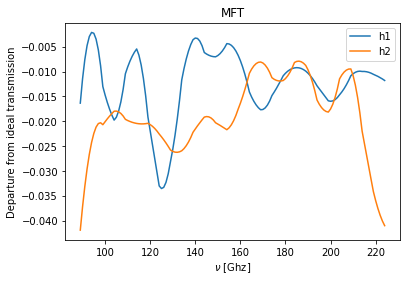

In [7]:
plt.plot(nu,h1,label='h1')
plt.plot(nu,h2,label='h2')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal transmission')
plt.title('MFT')
plt.legend()

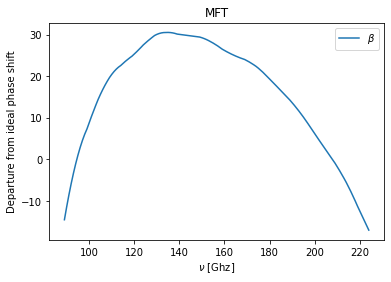

In [22]:
plt.plot(nu,beta,label=r'$\beta$')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal phase shift')
plt.title('MFT')
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [8]:
i_i = np.where(nu == 89)[0][0]
i_f = np.where(nu == 111)[0][0]
Nu=nu[i_i:i_f]
H1=h1[i_i:i_f]
H2=h2[i_i:i_f]
Beta=beta[i_i:i_f]
Z1=z1[i_i:i_f]
Z2=z2[i_i:i_f]

In [9]:
np.savetxt('MFT_100_h_beta_z.txt', np.column_stack((Nu,H1,H2,Beta,Z1,Z2))) 

In [29]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
       } 
       
      }

## Fill tod and then build map

In [30]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
#Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

#mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
#maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [31]:
sim.parameter_file = par   #setting the parameter file
hwp_sys = lbs.HwpSys(sim)

Text(0, 0.5, 'transmission')

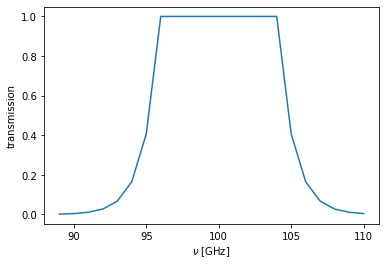

In [61]:
bandpass_parameters={'low edge': 96,'high edge': 104,'alpha': 0.9}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.decaying_bandpass(Nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'],
                                           bandpass_parameters['alpha'])
plt.plot(Nu,transmission)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

the next command will take a while with band integration, since it has to generate one map per frequency

In [32]:
hwp_sys.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': 96,
                                            'high edge': 104,'alpha': 0.9}, #140 GHz frequency band
                       include_beam_throughput=True
                      )

[2021-12-30 16:42:45,942 INFO MPI#0000] using the passed instrument to generate maps
[2021-12-30 16:42:45,943 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 16:42:45,954 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 16:42:46,206 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:42:46,206 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 16:42:47,093 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 16:42:47,095 INFO MPI#0000] NSIDE = 512
[2021-12-30 16:42:47,096 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 16:42:47,096 INFO MPI#0000] INDXS

***************** D
***************** D
***************** D


[2021-12-30 16:42:47,955 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 16:42:52,942 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:42:52,944 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:42:52,944 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:42:52,945 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:42:58,989 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:42:58,989 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:42:58,990 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:42:58,990 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:43:05,468 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:43:05,468 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:43:05,469 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:43:05,469

[2021-12-30 16:45:26,586 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:26,586 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:26,587 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:34,011 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:34,011 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:34,012 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:34,012 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:41,216 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:41,218 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:41,219 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:41,220 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:48,197 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:45:48,199 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:45:48,201 INFO MPI#0000] Sigma

[2021-12-30 16:48:40,979 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:48:48,567 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:48:48,568 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:48:48,568 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:48:48,569 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:48:55,924 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:48:55,926 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:48:55,928 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:48:55,929 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:49:03,203 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:49:03,206 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:49:03,208 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:49:03,210 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:49:10,915 INFO MPI#0000] Sigma

[2021-12-30 16:51:43,516 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:51:43,516 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:51:43,516 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:51:51,244 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:51:51,245 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:51:51,245 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:51:51,245 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:51:58,871 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:51:58,872 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:51:58,873 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:51:58,874 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:52:06,896 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:52:06,897 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:52:06,897 INFO MPI#0000] Sigma

In [33]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)
obs.tod *= 2.0 #

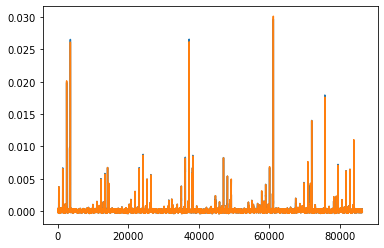

In [37]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])

In [38]:
m = lbs.make_bin_map([obs],nside).T

UNSEEN due to low coverage of the sky with short mission time (?)

In [39]:
for i in range(3):
    ind = np.where(m[i] == hp.UNSEEN)[0]
    print (ind)
    m[i,ind] = 0

[      0       1       2 ... 3145725 3145726 3145727]
[      0       1       2 ... 3145725 3145726 3145727]
[      0       1       2 ... 3145725 3145726 3145727]


Uncomment the cell below if you have generated the map externally, in a case without band integration, to compare the output map with the input one

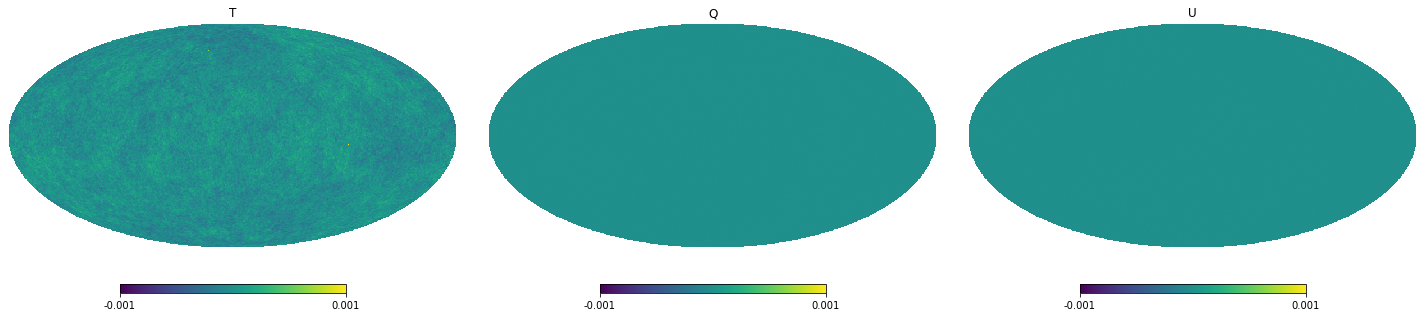

In [69]:
#fig = plt.figure(figsize=(20,10))
#hp.mollview(m[0]-maps[0],sub=131,title='T',min=-1e-3,max=1e-3)
#hp.mollview(m[1]-maps[1],sub=132,title='Q',min=-1e-3,max=1e-3)
#hp.mollview(m[2]-maps[2],sub=133,title='U',min=-1e-3,max=1e-3)

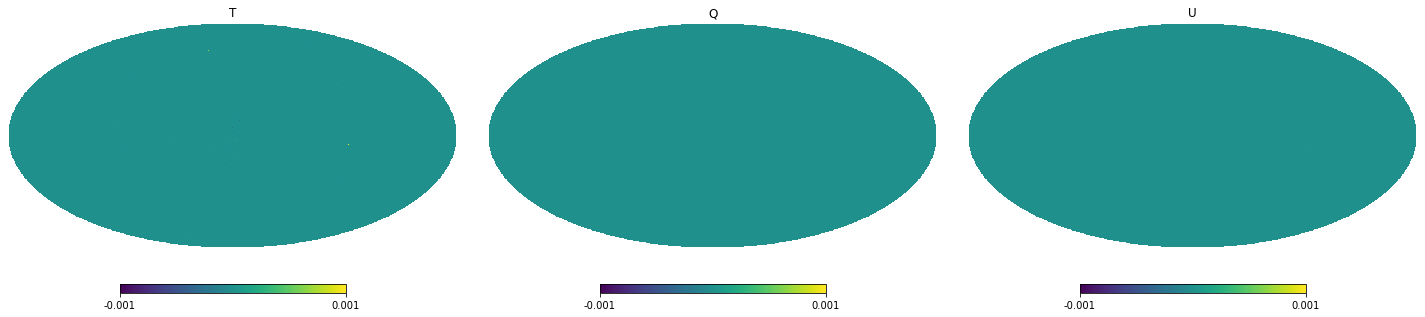

In [40]:
fig = plt.figure(figsize=(20,10))
hp.mollview(m[0],sub=131,title='T',min=-1e-3,max=1e-3)
hp.mollview(m[1],sub=132,title='Q',min=-1e-3,max=1e-3)
hp.mollview(m[2],sub=133,title='U',min=-1e-3,max=1e-3)

## Built map on the fly

In [12]:
#obs.tod not allocated
obs = lbs.Observation([asdict(d) for d in dets],
                      int(sim.duration_s*sampling),
                      sim.start_time,
                      sampling,
                      allocate_tod=False
                     )
pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [15]:
sim.parameter_file = par   #setting the parameter file
hwp_sys = lbs.HwpSys(sim)

In [16]:
#Here the obs.tod is not filled
hwp_sys.set_parameters(#maps=maps,
                       integrate_in_band=True,
                       correct_in_solver=False,
                       built_map_on_the_fly=True,
                       nside=nside,
                       bandpass_parameters={'low edge': 96,
                                            'high edge': 104,'alpha': 0.9}, #140 GHz frequency band
                       include_beam_throughput=True
                      )

[2021-12-30 15:59:46,548 INFO MPI#0000] using the passed instrument to generate maps
[2021-12-30 15:59:46,550 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 15:59:46,565 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 15:59:46,778 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 15:59:46,778 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 15:59:47,704 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 15:59:47,706 INFO MPI#0000] NSIDE = 512
[2021-12-30 15:59:47,706 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 15:59:47,707 INFO MPI#0000] INDXS

***************** D
***************** D
***************** D


[2021-12-30 15:59:48,471 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 15:59:53,360 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 15:59:53,361 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 15:59:53,363 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 15:59:53,364 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 15:59:59,379 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 15:59:59,379 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 15:59:59,380 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 15:59:59,380 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:00:05,784 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:00:05,785 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:00:05,785 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:00:05,786

[2021-12-30 16:02:29,941 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:29,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:29,941 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:37,504 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:37,504 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:37,505 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:37,505 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:45,199 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:45,200 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:45,200 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:45,201 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:52,961 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:02:52,962 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:02:52,963 INFO MPI#0000] Sigma

[2021-12-30 16:05:34,721 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:42,277 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:42,277 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:42,278 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:42,278 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:49,734 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:49,735 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:49,735 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:49,736 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:57,289 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:57,290 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:05:57,290 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:05:57,291 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:06:04,977 INFO MPI#0000] Sigma

[2021-12-30 16:08:26,138 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:26,139 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:26,139 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:33,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:33,942 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:33,942 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:33,943 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:41,858 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:41,859 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:41,859 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:41,860 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:49,645 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 16:08:49,646 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2021-12-30 16:08:49,647 INFO MPI#0000] Sigma

In [17]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)

In [18]:
m = hwp_sys.make_map([obs])